In [2]:
pip install gym torch

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
Note: you may need to restart the kernel to use updated packages.


# PyTorch optimizer parameter update

In [13]:
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Categorical

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.network(state)


In [14]:
def actor_critic(env, actor, critic, episode, actor_optimizer, critic_optimizer, gamma=0.99, T=1000):
    actor.train()
    critic.train()

    state,_ = env.reset()
    
    log_prob_actions = []
    values = []
    rewards = []
    episode_reward = 0

    for t in range(T):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = actor(state)
        value = critic(state)
        dist = Categorical(probs)
        action = dist.sample()
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward
        
        log_prob_action = dist.log_prob(action)
        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float))

        if done:
            print(f"Episode {episode} finished with total reward {episode_reward}")
            break
        state = next_state

    actor_loss, critic_loss = compute_loss(log_prob_actions, values, rewards, gamma)

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    return episode_reward

In [15]:
def compute_loss(log_prob_actions, values, rewards, gamma):
    returns = []
    Gt = 0
    pw = 0
    for reward in reversed(rewards):
        Gt = reward + gamma ** pw * Gt
        pw += 1
        returns.insert(0, Gt)

    log_prob_actions = torch.cat(log_prob_actions)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values
    actor_loss = -(log_prob_actions * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    return actor_loss, critic_loss

In [18]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.01)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.01)

rewards = []

for episode in range(300):
    episode_reward = actor_critic(env, actor, critic, episode, actor_optimizer, critic_optimizer)
    rewards.append(episode_reward)


Episode 0 finished with total reward 14.0
Episode 1 finished with total reward 11.0
Episode 2 finished with total reward 11.0
Episode 3 finished with total reward 13.0
Episode 4 finished with total reward 10.0
Episode 5 finished with total reward 12.0
Episode 6 finished with total reward 11.0
Episode 7 finished with total reward 10.0
Episode 8 finished with total reward 9.0
Episode 9 finished with total reward 9.0
Episode 10 finished with total reward 9.0
Episode 11 finished with total reward 10.0
Episode 12 finished with total reward 10.0
Episode 13 finished with total reward 10.0
Episode 14 finished with total reward 9.0
Episode 15 finished with total reward 10.0
Episode 16 finished with total reward 11.0
Episode 17 finished with total reward 10.0
Episode 18 finished with total reward 10.0
Episode 19 finished with total reward 9.0
Episode 20 finished with total reward 10.0
Episode 21 finished with total reward 10.0
Episode 22 finished with total reward 10.0
Episode 23 finished with t

Episode 209 finished with total reward 28.0
Episode 210 finished with total reward 23.0
Episode 211 finished with total reward 70.0
Episode 212 finished with total reward 26.0
Episode 213 finished with total reward 8.0
Episode 214 finished with total reward 20.0
Episode 215 finished with total reward 26.0
Episode 216 finished with total reward 13.0
Episode 217 finished with total reward 17.0
Episode 218 finished with total reward 9.0
Episode 219 finished with total reward 11.0
Episode 220 finished with total reward 27.0
Episode 221 finished with total reward 21.0
Episode 222 finished with total reward 26.0
Episode 223 finished with total reward 26.0
Episode 224 finished with total reward 28.0
Episode 225 finished with total reward 12.0
Episode 226 finished with total reward 26.0
Episode 227 finished with total reward 8.0
Episode 228 finished with total reward 28.0
Episode 229 finished with total reward 13.0
Episode 230 finished with total reward 32.0
Episode 231 finished with total rew

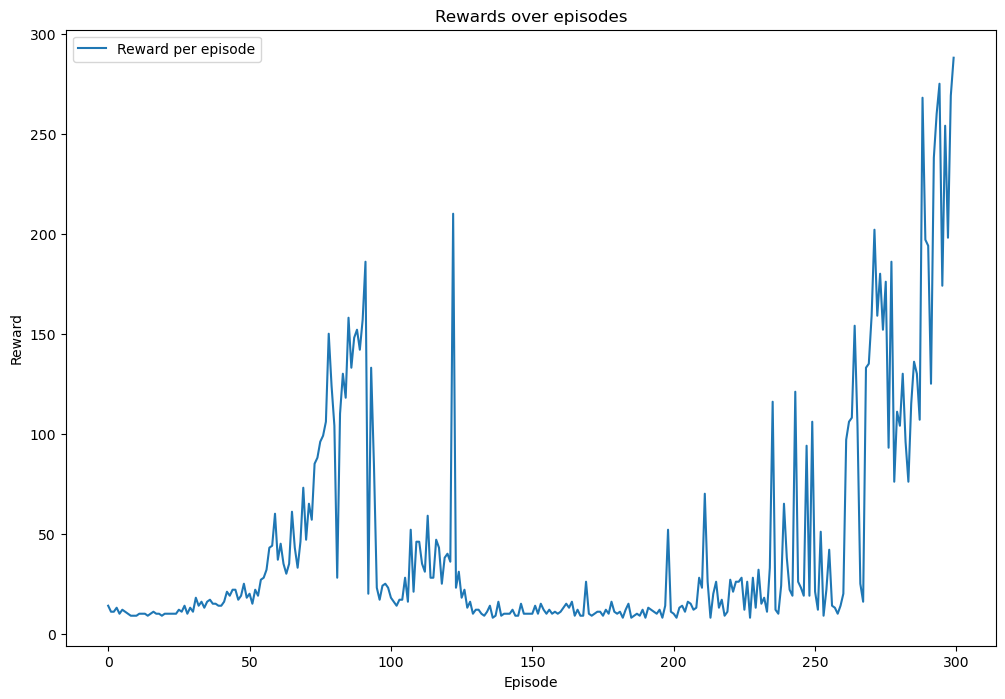

In [19]:
plt.figure(figsize=(12,8))
plt.plot(rewards, label='Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.legend()
plt.show()

# Manual implementation of parameter updates

In [20]:
import gym
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Categorical

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.network(state)


In [21]:
def actor_critic(env, actor, critic, episode, actor_lr=0.01, critic_lr=0.01, gamma=0.99, T=1000):
    actor.train()
    critic.train()

    state,_ = env.reset()
    
    log_prob_actions = []
    values = []
    rewards = []
    episode_reward = 0

    for t in range(T):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = actor(state)
        value = critic(state)
        dist = Categorical(probs)
        action = dist.sample()
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward
        
        log_prob_action = dist.log_prob(action)
        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float))

        if done:
            print(f"Episode {episode} finished with total reward {episode_reward}")
            break
        state = next_state

    actor_loss, critic_loss = compute_loss(log_prob_actions, values, rewards, gamma)

    for param in actor.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
    actor_loss.backward()
    
    for param in actor.parameters():
        param.data -= actor_lr * param.grad.data
        
    for param in critic.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
    critic_loss.backward()
    for param in critic.parameters():
        param.data -= critic_lr * param.grad.data
    return episode_reward


In [22]:

def compute_loss(log_prob_actions, values, rewards, gamma):
    returns = []
    Gt = 0
    pw = 0
    for reward in reversed(rewards):
        Gt = reward + gamma ** pw * Gt
        pw += 1
        returns.insert(0, Gt)

    log_prob_actions = torch.cat(log_prob_actions)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values
    actor_loss = -(log_prob_actions * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    return actor_loss, critic_loss



In [23]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

rewards = []

for episode in range(1000):
    episode_reward = actor_critic(env, actor, critic, episode)
    rewards.append(episode_reward)

    
    

Episode 0 finished with total reward 19.0
Episode 1 finished with total reward 12.0
Episode 2 finished with total reward 12.0
Episode 3 finished with total reward 14.0
Episode 4 finished with total reward 19.0
Episode 5 finished with total reward 19.0
Episode 6 finished with total reward 31.0
Episode 7 finished with total reward 10.0
Episode 8 finished with total reward 23.0
Episode 9 finished with total reward 20.0
Episode 10 finished with total reward 11.0
Episode 11 finished with total reward 45.0
Episode 12 finished with total reward 18.0
Episode 13 finished with total reward 23.0
Episode 14 finished with total reward 18.0
Episode 15 finished with total reward 15.0
Episode 16 finished with total reward 11.0
Episode 17 finished with total reward 23.0
Episode 18 finished with total reward 9.0
Episode 19 finished with total reward 10.0
Episode 20 finished with total reward 14.0
Episode 21 finished with total reward 10.0
Episode 22 finished with total reward 17.0
Episode 23 finished wi

Episode 194 finished with total reward 12.0
Episode 195 finished with total reward 8.0
Episode 196 finished with total reward 10.0
Episode 197 finished with total reward 10.0
Episode 198 finished with total reward 10.0
Episode 199 finished with total reward 10.0
Episode 200 finished with total reward 17.0
Episode 201 finished with total reward 9.0
Episode 202 finished with total reward 14.0
Episode 203 finished with total reward 10.0
Episode 204 finished with total reward 13.0
Episode 205 finished with total reward 9.0
Episode 206 finished with total reward 12.0
Episode 207 finished with total reward 11.0
Episode 208 finished with total reward 16.0
Episode 209 finished with total reward 10.0
Episode 210 finished with total reward 16.0
Episode 211 finished with total reward 11.0
Episode 212 finished with total reward 11.0
Episode 213 finished with total reward 14.0
Episode 214 finished with total reward 14.0
Episode 215 finished with total reward 10.0
Episode 216 finished with total rew

Episode 396 finished with total reward 11.0
Episode 397 finished with total reward 13.0
Episode 398 finished with total reward 12.0
Episode 399 finished with total reward 11.0
Episode 400 finished with total reward 11.0
Episode 401 finished with total reward 11.0
Episode 402 finished with total reward 10.0
Episode 403 finished with total reward 11.0
Episode 404 finished with total reward 9.0
Episode 405 finished with total reward 9.0
Episode 406 finished with total reward 9.0
Episode 407 finished with total reward 12.0
Episode 408 finished with total reward 10.0
Episode 409 finished with total reward 9.0
Episode 410 finished with total reward 14.0
Episode 411 finished with total reward 14.0
Episode 412 finished with total reward 11.0
Episode 413 finished with total reward 14.0
Episode 414 finished with total reward 16.0
Episode 415 finished with total reward 10.0
Episode 416 finished with total reward 14.0
Episode 417 finished with total reward 11.0
Episode 418 finished with total rewa

Episode 587 finished with total reward 16.0
Episode 588 finished with total reward 46.0
Episode 589 finished with total reward 24.0
Episode 590 finished with total reward 19.0
Episode 591 finished with total reward 31.0
Episode 592 finished with total reward 11.0
Episode 593 finished with total reward 70.0
Episode 594 finished with total reward 19.0
Episode 595 finished with total reward 22.0
Episode 596 finished with total reward 63.0
Episode 597 finished with total reward 22.0
Episode 598 finished with total reward 42.0
Episode 599 finished with total reward 72.0
Episode 600 finished with total reward 17.0
Episode 601 finished with total reward 45.0
Episode 602 finished with total reward 18.0
Episode 603 finished with total reward 19.0
Episode 604 finished with total reward 31.0
Episode 605 finished with total reward 45.0
Episode 606 finished with total reward 63.0
Episode 607 finished with total reward 29.0
Episode 608 finished with total reward 58.0
Episode 609 finished with total 

Episode 778 finished with total reward 24.0
Episode 779 finished with total reward 23.0
Episode 780 finished with total reward 81.0
Episode 781 finished with total reward 43.0
Episode 782 finished with total reward 40.0
Episode 783 finished with total reward 50.0
Episode 784 finished with total reward 23.0
Episode 785 finished with total reward 35.0
Episode 786 finished with total reward 81.0
Episode 787 finished with total reward 39.0
Episode 788 finished with total reward 16.0
Episode 789 finished with total reward 24.0
Episode 790 finished with total reward 72.0
Episode 791 finished with total reward 29.0
Episode 792 finished with total reward 52.0
Episode 793 finished with total reward 19.0
Episode 794 finished with total reward 23.0
Episode 795 finished with total reward 23.0
Episode 796 finished with total reward 21.0
Episode 797 finished with total reward 46.0
Episode 798 finished with total reward 31.0
Episode 799 finished with total reward 71.0
Episode 800 finished with total 

Episode 969 finished with total reward 80.0
Episode 970 finished with total reward 34.0
Episode 971 finished with total reward 31.0
Episode 972 finished with total reward 19.0
Episode 973 finished with total reward 33.0
Episode 974 finished with total reward 52.0
Episode 975 finished with total reward 24.0
Episode 976 finished with total reward 21.0
Episode 977 finished with total reward 25.0
Episode 978 finished with total reward 27.0
Episode 979 finished with total reward 22.0
Episode 980 finished with total reward 26.0
Episode 981 finished with total reward 31.0
Episode 982 finished with total reward 22.0
Episode 983 finished with total reward 16.0
Episode 984 finished with total reward 20.0
Episode 985 finished with total reward 57.0
Episode 986 finished with total reward 25.0
Episode 987 finished with total reward 24.0
Episode 988 finished with total reward 38.0
Episode 989 finished with total reward 19.0
Episode 990 finished with total reward 40.0
Episode 991 finished with total 

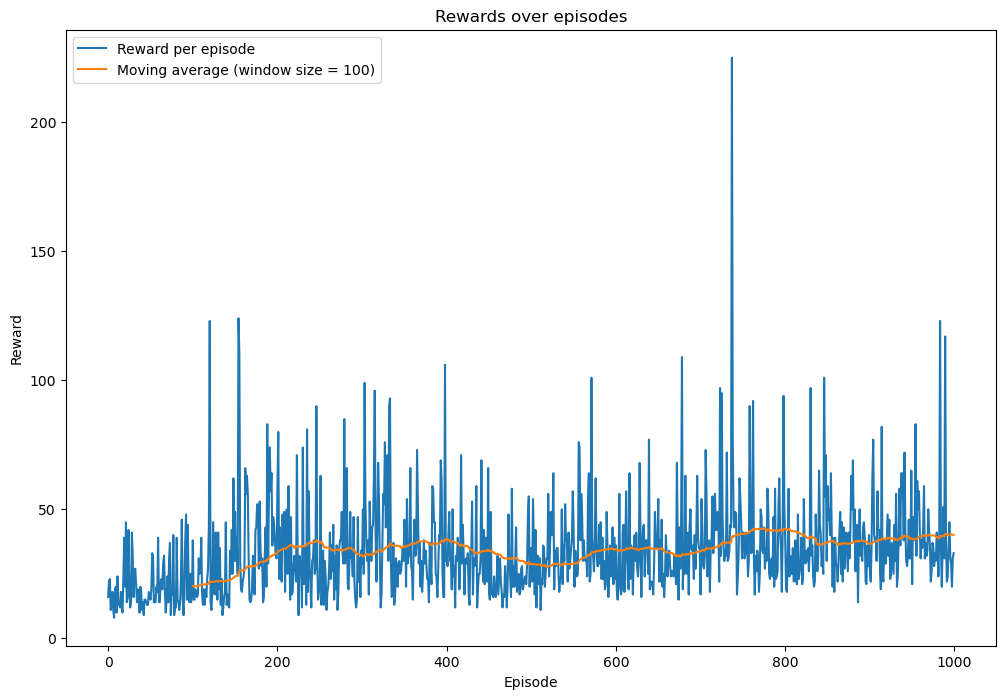

In [44]:
plt.figure(figsize=(12,8))
plt.plot(rewards, label='Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.show()